In [ ]:
from dataclasses import dataclass
from typing import List, Tuple
import numpy as np

class Worldstate:
  @dataclass
  class Barrier:
    axis: int
    position: float
    bounds: Tuple[float, float]

  def __init__(self, position: np.ndarray, barriers: List['Worldstate.Barrier'], background_seed: int) -> None:
    self.position = position
    self.barrier_width = 0.003
    self.barriers = barriers
    self.barrier_endcaps = sum([[
      Worldstate.Barrier(
        0 if barrier.axis == 1 else 1,
        bound + offset,
        (barrier.position - self.barrier_width, barrier.position + self.barrier_width)
      ) for bound, offset in zip(barrier.bounds, [self.barrier_width, -self.barrier_width])
    ] for barrier in barriers], [])
    self.background_seed = background_seed

  @staticmethod
  def random(
    barriers_per_dim_mean: float = 80.0,
    barriers_per_dim_std: float = 5.0,
    barrier_length_mean: float = 0.1,
    barrier_length_std: float = 0.1
  ) -> 'Worldstate':
    # generate random barriers
    dims = 2
    barriers = []
    for axis, barrier_count in enumerate(
      np.random.normal(
        barriers_per_dim_mean, barriers_per_dim_std, dims
      ).round().clip(min=0).astype(np.uint32)
    ):
      barrier_positions = np.random.rand(barrier_count)
      barrier_centers = np.random.rand(barrier_count)
      barrier_lengths = np.random.normal(barrier_length_mean, barrier_length_std, barrier_count)
      for position, center, length in zip(barrier_positions, barrier_centers, barrier_lengths):
        if length <= 0:
          continue
        barriers.append(
          Worldstate.Barrier(
            axis, position, (center - length / 2, center + length / 2),
          )
        )

    return Worldstate(np.full(dims, 0.5), barriers, np.random.randint(0, 2**31))
  
  def act(self, action: np.ndarray, scale: float = 0.05):
    dims = 2

    effective_action = action * scale
    for axis in range(dims):
      if abs(effective_action[axis]) < 1e-8:
        continue
      alternate_axes = list(range(dims))
      alternate_axes.remove(axis)

      for barrier in self.barriers + self.barrier_endcaps:
        if barrier.axis != axis:
          continue
        start, stop = barrier.bounds
        for barrier_border in [barrier.position - self.barrier_width, barrier.position + self.barrier_width]:
          if effective_action[axis] == 0:
            continue
          distance_to_border = barrier_border - self.position[axis]
          steps_until_contact = distance_to_border / effective_action[axis]
          if steps_until_contact < 0:
            continue
          counteraxial_contact_position = self.position[alternate_axes] + steps_until_contact * effective_action[alternate_axes]
          if start < counteraxial_contact_position < stop:
            effective_action[axis] *= 1 if steps_until_contact == 0 and (effective_action[axis] > 0) != (barrier.position - self.position[axis] > 0) else min(steps_until_contact, 1)

        # if barrier.axis == axis and start <= self.position[alternate_axes] < stop:
        #   if axial_position <= barrier.position - self.barrier_width <= axial_position + offset:
        #     offset = (barrier.position - self.barrier_width) - axial_position
        #   elif axial_position >= barrier.position + self.barrier_width >= axial_position + offset:
        #     offset = (barrier.position + self.barrier_width) - axial_position
      # effective_action[axis] = offset
    self.position += effective_action

  def render(self, resolution: int, egocentric: bool = False, egocentric_camera_size: float = 0.1, point_radius: float = 0.05) -> np.ndarray:
    dims = 2
    def to_pixel_coords(array: np.ndarray, axis: int | None = None, clip: bool = False):
      if egocentric:
        pixel_position = (
          (array - self.position if axis is None else array - self.position[axis])
          / egocentric_camera_size
          + 0.5
        ) * resolution
      else:
        pixel_position = (array * resolution).round().astype(np.int32)
      return pixel_position.clip(0, resolution - 1) if clip else pixel_position
      
    canvas = np.zeros((resolution, resolution, 3))
    if egocentric:
      corner1, corner2 = np.full(2, self.position - egocentric_camera_size / 2), np.full(2, self.position + egocentric_camera_size / 2)
    else:
      corner1, corner2 = np.zeros(2), np.ones(2)
    canvas[:, :, 2] = sample_2d_perlin_noise_region(self.background_seed, corner1, corner2, (resolution, resolution), 0.1)
    # TODO better
    x, y = to_pixel_coords(self.position)
    canvas[x, y, 0] = 1.0

    for barrier in self.barriers:
      counter_axis = 0 if barrier.axis == 1 else 1
      position = to_pixel_coords(np.array([barrier.position]), axis=barrier.axis).round().astype(np.int32)
      bounds = to_pixel_coords(np.array(barrier.bounds), axis=counter_axis, clip=True)
      pixel_coordinates = np.concatenate((position, bounds))
      if ((pixel_coordinates < 0) | (pixel_coordinates >= resolution)).any():
        continue
      indices: List[int | slice] = [0] * dims
      indices[barrier.axis] = position.item()
      indices[counter_axis] = slice(bounds[0].item(), bounds[1].item())
      canvas[indices[0], indices[1], 1] = 1.0

    return canvas
  

def sample_2d_perlin_noise_region(global_seed: int, corner1: np.ndarray, corner2: np.ndarray, pixel_resolution: Tuple[int, int], noise_resolution: float) -> np.ndarray:
    fade = lambda t: t * t * t * (t * (t * 6 - 15) + 10)
    lerp = lambda a, b, t: a + t * (b - a)
    def gradient(h, x, y):
        g = h & 3
        return np.where(g < 2, x, -x) + np.where(g & 1 == 0, y, -y)
    
    x_coords = np.linspace(corner1[0], corner2[0], pixel_resolution[0])
    y_coords = np.linspace(corner1[1], corner2[1], pixel_resolution[1])
    X, Y = np.meshgrid(x_coords, y_coords, indexing='ij')
    X_grid, Y_grid = X / noise_resolution, Y / noise_resolution
    X0, Y0 = np.floor(X_grid).astype(int), np.floor(Y_grid).astype(int)
    X1, Y1 = X0 + 1, Y0 + 1
    fx, fy = X_grid - X0, Y_grid - Y0
    u, v = fade(fx), fade(fy)
    
    rng = np.random.Generator(np.random.PCG64(global_seed))
    p = np.arange(512, dtype=int)
    rng.shuffle(p[:256])
    p[256:] = p[:256]
    hash_coord = lambda x, y: p[p[x & 255] + (y & 255)]
    
    h00, h10, h01, h11 = hash_coord(X0, Y0), hash_coord(X1, Y0), hash_coord(X0, Y1), hash_coord(X1, Y1)
    g00, g10, g01, g11 = gradient(h00, fx, fy), gradient(h10, fx - 1, fy), gradient(h01, fx, fy - 1), gradient(h11, fx - 1, fy - 1)
    result = lerp(lerp(g00, g10, u), lerp(g01, g11, u), v)
    
    return np.clip((result + 1) / 2, 0, 1)

[Worldstate.Barrier(axis=0, position=np.float64(0.5488728473811135), bounds=(np.float64(0.8213826145672236), np.float64(0.8391754220368186))), Worldstate.Barrier(axis=0, position=np.float64(0.7554563563416352), bounds=(np.float64(0.8944821818328789), np.float64(1.0268059355712245))), Worldstate.Barrier(axis=0, position=np.float64(0.505550172384762), bounds=(np.float64(0.015134980331478011), np.float64(0.09133602010832617))), Worldstate.Barrier(axis=0, position=np.float64(0.6158799825325677), bounds=(np.float64(0.32899203117206377), np.float64(0.5244465003599188))), Worldstate.Barrier(axis=0, position=np.float64(0.05086915417653237), bounds=(np.float64(0.8767179695864706), np.float64(1.06795353420082))), Worldstate.Barrier(axis=0, position=np.float64(0.7111643057007886), bounds=(np.float64(0.67910629810484), np.float64(0.8657789296972923))), Worldstate.Barrier(axis=0, position=np.float64(0.38093588878853946), bounds=(np.float64(0.2822651269698062), np.float64(0.3155840761540638))), Worl

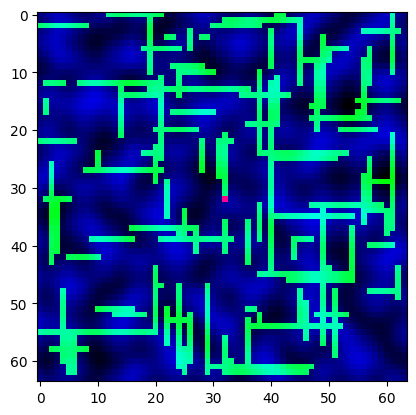

In [181]:
import matplotlib.pyplot as plt

state = Worldstate.random()
print(state.barriers)
image = state.render(64)
plt.imshow(image)

In [159]:
# TEST OUT BARRIERS

import cv2

state = Worldstate.random()
ORIGINAL_RESOLUTION = 64
UPSCALE_RESOLUTION = 512
EGOCENTRIC = True
EGOCENTRIC_CAMERA_SIZE = 0.2

def render():
  return cv2.resize(
    cv2.cvtColor(
      state.render(ORIGINAL_RESOLUTION, egocentric=EGOCENTRIC, egocentric_camera_size=EGOCENTRIC_CAMERA_SIZE).astype(np.float32),
      cv2.COLOR_RGB2BGR
    ),
    (UPSCALE_RESOLUTION, UPSCALE_RESOLUTION),
    interpolation=cv2.INTER_NEAREST
  )

def on_click(event, x, y, flags, param):
  if event != cv2.EVENT_LBUTTONDOWN:
    return
  click_position = np.array([y, x]) / UPSCALE_RESOLUTION
  if EGOCENTRIC:
    displacement = (click_position - 0.5) * EGOCENTRIC_CAMERA_SIZE
  else:
    displacement = click_position - state.position
  state.act(displacement, scale=1)
  cv2.imshow('worldstate', render())

cv2.imshow('worldstate', render())
cv2.setMouseCallback('worldstate', on_click)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# GENERATE DATA

import os
from pathlib import Path
from typing import Callable

import pickle
from tqdm import tqdm

def generate_dataset(dataset_dir: Path | str, trajectory_count: int, trajectory_length: int, create_policy: Callable[[Worldstate], Callable[[Worldstate], np.ndarray]]):
  dataset_dir = Path(dataset_dir)
  if not dataset_dir.parent.exists():
    raise FileNotFoundError(f'`{dataset_dir.parent}` does not exist.')
  os.mkdir(dataset_dir)
  
  for trajectory_index in tqdm(range(trajectory_count), desc='Generating trajectories'):
    trajectory_dir = dataset_dir / f'trajectory{trajectory_index}'
    os.mkdir(trajectory_dir)

    state = Worldstate.random()
    policy = create_policy(state)
    position = np.zeros((trajectory_length, 2))
    for step_index in range(trajectory_length):
      image = cv2.cvtColor((state.render(resolution=64, egocentric=True, egocentric_camera_size=0.2) * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
      cv2.imwrite(str(trajectory_dir / f'{step_index}.jpg'), image)
      position[step_index] = state.position
      action = policy(state)
      state.act(action, scale=1.0)
    with open(trajectory_dir / 'traj_data.pkl', 'wb') as f:
      pickle.dump({'position': position, 'yaw': np.zeros(trajectory_length)}, f)

In [197]:
class WindingWalkPolicy:
  def __init__(self, step_size: float = 0.01, max_wind_per_step: float = 2.0) -> None:
    self.step_size = step_size
    self.max_angular_deviation = max_wind_per_step
    self.angle = np.random.rand() * 2 * np.pi

  def __call__(self, _) -> np.ndarray:
    self.angle += 2 * (np.random.rand() - 0.5) * self.max_angular_deviation
    return self.step_size * np.array([np.cos(self.angle), np.sin(self.angle)])

generate_dataset('D:/datasets/nav2d/dataset1', trajectory_count=1000, trajectory_length=100, create_policy=lambda _: WindingWalkPolicy())